# Keras Fine Tuning on Cloud Machine Learning Engine
This notebook shows how to create transfer learning model using Keras, and train on ML Engine then serve on ML Engine's Online Prediction.  

Install cloudmlmagic ahead of running.

In [2]:
# !pip install cloudmlmagic

Load cloudmlmagic extension

In [3]:
%load_ext cloudmlmagic

Initialize and setup ML Engine parameters.  
<font color="red">Change PROJECTID and BUCKET</font>  

Following dict will be written in setup.py of your package,  
so list up neccesary packages of your code.

In [4]:
%%ml_init -projectId PROJECTID -bucket BUCKET -scaleTier BASIC_GPU -region asia-east1 -runtimeVersion 1.2
{'install_requires': ['keras', 'h5py', 'Pillow']}

Load InceptionV3 model

In [5]:
%%ml_code

from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights='imagenet')

Using TensorFlow backend.


Load dataset

In [6]:
%%ml_code

from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from io import BytesIO
import numpy as np
import pandas as pd
import requests

url = 'https://github.com/hayatoy/deep-learning-datasets/releases/download/v0.1/tl_opera_capitol.npz'
response = requests.get(url)
dataset = np.load(BytesIO(response.content))

X_dataset = dataset['features']
y_dataset = dataset['labels']

Split dataset for train and test

In [7]:
%%ml_code

from keras.utils import np_utils
from sklearn.model_selection import train_test_split

X_dataset = preprocess_input(X_dataset)
y_dataset = np_utils.to_categorical(y_dataset)
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, test_size=0.2, random_state=42)

The code cell above won't be included in the package being deployed on ML Engine.  
Just to clarify that normal InceptionV3 model cannot predict correctly with the Opera/Capitol dataset.

In [8]:
x = X_dataset[0]
x = np.expand_dims(x, axis=0)

preds = model.predict(x)
print('Predicted:')
for p in decode_predictions(preds, top=5)[0]:
    print("Score {}, Label {}".format(p[2], p[1]))

Predicted:
Score 0.110657587647, Label wreck
Score 0.0671983659267, Label lakeside
Score 0.0309968702495, Label seashore
Score 0.0249739717692, Label breakwater
Score 0.0229569561779, Label fountain


Visualize last layers of InceptionV3

In [9]:
pd.DataFrame(model.layers).tail()

,0
308,<keras.layers.merge.Concatenate object at 0x7f...
309,<keras.layers.core.Activation object at 0x7fb7...
310,<keras.layers.merge.Concatenate object at 0x7f...
311,<keras.layers.pooling.GlobalAveragePooling2D o...
312,<keras.layers.core.Dense object at 0x7fb7a1a5b...


In [10]:
%ml_code

from keras.models import Model

# Intermediate layer
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[311].output)

Extract intermediate features

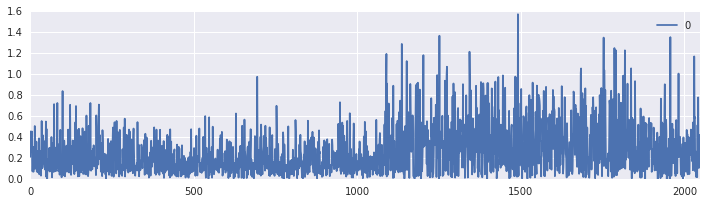

In [11]:
x = np.expand_dims(X_dataset[0], axis=0)
feature = intermediate_layer_model.predict(x)
pd.DataFrame(feature.reshape(-1,1)).plot(figsize=(12, 3))

Append dense layer at the last

In [12]:
%%ml_code

from keras.layers import Dense

# Append dense layer
x = intermediate_layer_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Transfer learning model, all layers are trainable at this moment
transfer_model = Model(inputs=intermediate_layer_model.input, outputs=predictions)

print(pd.DataFrame(transfer_model.layers).tail())

# Freeze all layers
for layer in transfer_model.layers:
    layer.trainable = False

# Unfreeze the last layers, so that only these layers are trainable.
transfer_model.layers[312].trainable = True
transfer_model.layers[313].trainable = True

transfer_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

                                                     0
309  <keras.layers.core.Activation object at 0x7fb7...
310  <keras.layers.merge.Concatenate object at 0x7f...
311  <keras.layers.pooling.GlobalAveragePooling2D o...
312  <keras.layers.core.Dense object at 0x7fb7a1216...
313  <keras.layers.core.Dense object at 0x7fb7a1216...


In [ ]:
%%ml_run cloud

import tensorflow as tf
from keras import backend as K

transfer_model.fit(X_train, y_train, epochs=20,
                   verbose=2,
                   validation_data=(X_test, y_test))
loss, acc = transfer_model.evaluate(X_test, y_test)
print('Loss {}, Accuracy {}'.format(loss, acc))

K.set_learning_phase(0)  # test
sess = K.get_session()

from tensorflow.python.framework import graph_util

# Make GraphDef of Transfer Model
g_trans = sess.graph
g_trans_def = graph_util.convert_variables_to_constants(sess,
                                                        g_trans.as_graph_def(),
                                                        [transfer_model.output.name.replace(':0','')])

# Image Converter Model
with tf.Graph().as_default() as g_input:
    input_b64 = tf.placeholder(shape=(1,), dtype=tf.string, name='input')
    input_bytes = tf.decode_base64(input_b64[0])
    image = tf.image.decode_image(input_bytes)
    image_f = tf.image.convert_image_dtype(image, dtype=tf.float32)
    input_image = tf.expand_dims(image_f, 0)
    output = tf.identity(input_image, name='input_image')

g_input_def = g_input.as_graph_def()



with tf.Graph().as_default() as g_combined:
    x = tf.placeholder(tf.string, name="input_b64")

    im, = tf.import_graph_def(g_input_def,
                              input_map={'input:0': x},
                              return_elements=["input_image:0"])

    pred, = tf.import_graph_def(g_trans_def,
                                input_map={transfer_model.input.name: im,
                                          'batch_normalization_1/keras_learning_phase:0': False},
                                return_elements=[transfer_model.output.name])

    with tf.Session() as sess2:
        inputs = {"inputs": tf.saved_model.utils.build_tensor_info(x)}
        outputs = {"outputs": tf.saved_model.utils.build_tensor_info(pred)}
        signature = tf.saved_model.signature_def_utils.build_signature_def(
            inputs=inputs,
            outputs=outputs,
            method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
        )

        # save as SavedModel
        b = tf.saved_model.builder.SavedModelBuilder('gs://BUCKET/keras-mlengine/savedmodel')
        b.add_meta_graph_and_variables(sess2,
                                       [tf.saved_model.tag_constants.SERVING],
                                       signature_def_map={'serving_default': signature})
        b.save()

In [ ]:
# This cell is to prevent "runAll".
# you must wait until ML Engine job finishes
raise Exception('wait until ml engine job finishes..')

Create Model and Version for Online Prediction

In [15]:
# !gcloud ml-engine models create OperaCapitol
!gcloud ml-engine versions create v1 --model OperaCapitol --runtime-version 1.2 --origin gs://BUCKET/keras-mlengine/savedmodel

Creating version (this might take a few minutes)......done.


Let's classify this image! This must be class 0..
<img src="opera.jpg">

In [16]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors

PROJECTID = 'PROJECTID'
projectID = 'projects/{}'.format(PROJECTID)
modelName = 'OperaCapitol'
modelID = '{}/models/{}'.format(projectID, modelName)

credentials = GoogleCredentials.get_application_default()
ml = discovery.build('ml', 'v1', credentials=credentials)

In [17]:
with open('opera.jpg', 'rb') as f:
    b64_x = f.read()
import base64
import json

b64_x = base64.urlsafe_b64encode(b64_x)
input_instance = dict(inputs=b64_x)
input_instance = json.loads(json.dumps(input_instance))
request_body = {"instances": [input_instance]}

request = ml.projects().predict(name=modelID, body=request_body)
try:
    response = request.execute()
except errors.HttpError as err:
    # Something went wrong with the HTTP transaction.
    # To use logging, you need to 'import logging'.
    print('There was an HTTP error during the request:')
    print(err._get_reason())
response

{u'predictions': [{u'outputs': [0.9974665641784668, 0.00253341649658978]}]}